# Microsoft Malware Prediction
### W207 Final Project

* Kevin Hartman
* Gunnar Mein
* Andrew Morris

The inspiration for this project came from a recent competition from Kaggle:
* https://www.kaggle.com/c/microsoft-malware-prediction

The motivation and prompt:
> The malware industry continues to be a well-organized, well-funded market dedicated to evading traditional security measures. Once a computer is infected by malware, criminals can hurt consumers and enterprises in many ways.  With more than one billion enterprise and consumer customers, Microsoft takes this problem very seriously and is deeply invested in improving security.

> As one part of their overall strategy for doing so, Microsoft is challenging the data science community to develop techniques to predict if a machine will soon be hit with malware. As with their previous, Malware Challenge (2015), Microsoft is providing Kagglers with an unprecedented malware dataset to encourage open-source progress on effective techniques for predicting malware occurrences.

> Can you help protect more than one billion machines from damage BEFORE it happens?

## Contents

<ol>
    <li><a href='#Setup'>Definitions and Setup</a></li>
    <li><a href='#Loading'>Loading the Data</a></li>
    <li><a href='#EDA'>Exploratory Data Analysis</a></li>
    <li><a href='#Cleaning'>Data Wrangling and Cleaning</a></li>
    <li><a href='#Encoding'>Encoding and Transformations</a></li>
    <li><a href='#Features'>Feature Selection</a></li>
    <li><a href='#Models'>Model Fitting and Evaluation</a></li>
    <li><a href='#NeuralNetwork'>Neural Network</a></li>
    <li><a href='#Conclusion'>Review and Conclusion</a></li>
    <li><a href='#Appendix'>Appendix</a></li>
</ol>

We used the following classifiers that were covered in the course:

- **k Nearest Neighbors** (week 2)
- **Decision Trees**, as well as **Random Forests**, **AdaBoost**, and **Gradient Boosting** (week 4)
- **Logistic Regression** (week 5)
- **Neural Networks** (week 7)
- **PCA and Gaussian Mixture Models** (weeks 9 and 10)


We did not pursue Naive Bayes (week 3), Stochastic Gradient Descent (week 6) or Support Vector Machines (week 8)*, or due to time constraints, and because our EDA did not provide enough support to investigate these approaches.

*Of note, we performed limited LinearSVM() modelling but the results showed the model just basically guessed all positives or all negatives.  This yielded low accuracy, so we discarded this model quickly.

## Setup

<a href='#Contents'>[Back to top]</a>

In [1]:
# Import required libraries for subsequent operations

import re
import time
import gc
import torch
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble._hist_gradient_boosting.utils import (get_equivalent_estimator)
from sklearn.metrics import zero_one_loss
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from torch.utils import data

%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') #hide warnings that arise from missing glyphs, deprecations, etc.

# set required global flags  

load_from_encoded_files = True # skip EDA, cleaning and encoding, and load from files
use_mini_files = True # load from mini sets when loading from encoded files
do_EDA = False    # EDA portion can be skipped if working further downstream
debug = True      # use small files to check basic functionality
save_data = False # not saving encoded files can save a lot of time

# here is where we decide what to load, and trigger the process

if load_from_encoded_files:
    if use_mini_files:
        filename_encoded_train = "data/mini_train_encoded.csv"
        filename_encoded_dev = "data/mini_dev_encoded.csv"
        filename_encoded_validate = "data/mini_validate_encoded.csv"
    else:
        filename_encoded_train = "data/train_encoded.csv"
        filename_encoded_dev = "data/dev_encoded.csv"
        filename_encoded_validate = "data/validate_encoded.csv"
else:
    if debug:
        filename_train = "data/debug/mini_initial_train.csv"
        filename_test = "data/debug/mini_initial_test.csv"
    else:
        filename_train = "data/train.csv"
        filename_test = "data/test.csv"

## Loading
Utility function for loading, and the actual load calls deciding betwen small debug versions (~60MB)
and the 4GB real files

<a href='#Contents'>[Back to top]</a>

In [2]:
# load with pre-informed data types for faster loading

def load_from_raw_data(filename):
   
    dtypes = {
        'MachineIdentifier':                                    'str',
        'ProductName':                                          'str',
        'EngineVersion':                                        'str',
        'AppVersion':                                           'str',
        'AvSigVersion':                                         'str',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float64',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'str',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'str',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'str',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'str',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

    df = pd.read_csv(filename, dtype=dtypes, engine='c')
    return df

def load_from_encoded_data(filename):
   
    dtypes = {
        'MachineIdentifier':                                    'int64',
        'ProductName':                                          'int64',
        'EngineVersion':                                        'int64',
        'AppVersion':                                           'int64',
        'AvSigVersion':                                         'int64',
        'RtpStateBitfield':                                     'int64',
        'Platform':                                             'int64',
        'Processor':                                            'int64',
        'OsVer':                                                'int64',
        'OsPlatformSubRelease':                                 'int64',
        'OsBuildLab':                                           'int64',
        'SkuEdition':                                           'int64',
        'SmartScreen':                                          'int64',
        'Census_MDC2FormFactor':                                'int64',
        'Census_DeviceFamily':                                  'int64',
        'Census_PrimaryDiskTypeName':                           'int64',
        'Census_ChassisTypeName':                               'int64',
        'Census_PowerPlatformRoleName':                         'int64',
        'Census_InternalBatteryType':                           'int64',
        'Census_OSVersion':                                     'int64',
        'Census_OSArchitecture':                                'int64',
        'Census_OSBranch':                                      'int64',
        'Census_OSEdition':                                     'int64',
        'Census_OSSkuName':                                     'int64',
        'Census_OSInstallTypeName':                             'int64',
        'Census_OSWUAutoUpdateOptionsName':                     'int64',
        'Census_GenuineStateName':                              'int64',
        'Census_ActivationChannel':                             'int64',
        'Census_FlightRing':                                    'int64',
        'RtpStateBitfield_wasna':                               'int64',
        'DefaultBrowsersIdentifier_wasna':                      'int64',
        'AVProductStatesIdentifier_wasna':                      'int64',
        'AVProductsInstalled_wasna':                            'int64',
        'AVProductsEnabled_wasna':                              'int64',
        'CityIdentifier_wasna':                                 'int64',
        'OrganizationIdentifier_wasna':                         'int64',
        'GeoNameIdentifier_wasna':                              'int64',
        'IsProtected_wasna':                                    'int64',
        'SMode_wasna':                                          'int64',
        'IeVerIdentifier_wasna':                                'int64',
        'Firewall_wasna':                                       'int64',
        'UacLuaenable_wasna':                                   'int64',
        'Census_OEMNameIdentifier_wasna':                       'int64',
        'Census_OEMModelIdentifier_wasna':                      'int64',
        'Census_ProcessorCoreCount_wasna':                      'int64',
        'Census_ProcessorManufacturerIdentifier_wasna':         'int64',
        'Census_ProcessorModelIdentifier_wasna':                'int64',
        'Census_PrimaryDiskTotalCapacity_wasna':                'int64',
        'Census_SystemVolumeTotalCapacity_wasna':               'int64',
        'Census_TotalPhysicalRAM_wasna':                        'int64',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches_wasna': 'int64',
        'Census_InternalPrimaryDisplayResolutionHorizontal_wasna': 'int64',
        'Census_InternalPrimaryDisplayResolutionVertical_wasna': 'int64',
        'Census_InternalBatteryNumberOfCharges_wasna':          'int64',
        'Census_OSInstallLanguageIdentifier_wasna':             'int64',
        'Census_IsFlightingInternal_wasna':                     'int64',
        'Census_IsFlightsDisabled_wasna':                       'int64',
        'Census_ThresholdOptIn_wasna':                          'int64',
        'Census_FirmwareManufacturerIdentifier_wasna':          'int64',
        'Census_IsWIMBootEnabled_wasna':                        'int64',
        'Census_IsVirtualDevice_wasna':                         'int64',
        'Census_IsAlwaysOnAlwaysConnectedCapable_wasna':        'int64',
        'Wdft_IsGamer_wasna':                                   'int64',
        'Wdft_RegionIdentifier_wasna':                          'int64',
        'Census_FirmwareVersionIdentifier_wasna':               'int64',
        'OsBuildLab_platform':                                  'float64',
        'OsBuildLab_release':                                   'float64',
        'IsBeta':                                               'int8',
        'IsSxsPassiveMode':                                     'int8',
        'HasTpm':                                               'int8',
        'AutoSampleOptIn':                                      'int8',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'HasDetections':                                        'int8',
        'CountryIdentifier':                                    'float64',
        'LocaleEnglishNameIdentifier':                          'float64',
        'OsBuild':                                              'float64',
        'OsSuite':                                              'int16',
        'Census_OSBuildNumber':                                 'float64',
        'Census_OSUILocaleIdentifier':                          'float64',
        'EngineVersion_major':                                  'int16',
        'EngineVersion_minor':                                  'int16',
        'EngineVersion_build1':                                 'int16',
        'EngineVersion_build2':                                 'int16',
        'AppVersion_major':                                     'int16',
        'AppVersion_minor':                                     'int16',
        'AppVersion_build1':                                    'int16',
        'AppVersion_build2':                                    'int16',
        'AvSigVersion_major':                                   'int16',
        'AvSigVersion_minor':                                   'int16',
        'AvSigVersion_build1':                                  'int16',
        'AvSigVersion_build2':                                  'int16',
        'Census_OSVersion_major':                               'int16',
        'Census_OSVersion_minor':                               'int16',
        'Census_OSVersion_build1':                              'int16',
        'Census_OSVersion_build2':                              'int16',
        'OsVer_major':                                          'int16',
        'OsVer_minor':                                          'int16',
        'OsVer_build1':                                         'int16',
        'OsVer_build2':                                         'int16',
        'OsBuildLab_major':                                     'float64',
        'OsBuildLab_minor':                                     'float64',
        'Census_OSBuildRevision':                               'int32',
        'OsBuildLab_build1':                                    'int32',
        'OsBuildLab_build2':                                    'float64',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float64',
        'IsProtected':                                          'float16',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float64',
        'Firewall':                                             'float16',
        'Census_ProcessorCoreCount':                            'float64',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_OSInstallLanguageIdentifier':                   'float64',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float64',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float64',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float64',
        'CityIdentifier':                                       'float64',
        'Census_OEMNameIdentifier':                             'float64',
        'Census_OEMModelIdentifier':                            'float64',
        'Census_ProcessorModelIdentifier':                      'float64',
        'Census_TotalPhysicalRAM':                              'float64',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float64',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float64',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float64',
        'Census_FirmwareVersionIdentifier':                     'float64',
        'UacLuaenable':                                         'float64',
        'Census_PrimaryDiskTotalCapacity':                      'float64',
        'Census_SystemVolumeTotalCapacity':                     'float64',
        'Census_InternalBatteryNumberOfCharges':                'float64',
        'EngineVersion_combined':                               'float64',
        'AppVersion_combined':                                  'float64',
        'AvSigVersion_combined':                                'float64',
        'Census_OSVersion_combined':                            'float64',
        'OsVer_combined':                                       'float64',
        'OsBuildLab_combined':                                  'float64'
        }

    df = pd.read_csv(filename, dtype=dtypes, engine='c')
    return df

In [3]:
if load_from_encoded_files:
    df_train = load_from_encoded_data(filename_encoded_train)
    train_labels = df_train['HasDetections']
    df_dev = load_from_encoded_data(filename_encoded_dev)
    dev_labels = df_dev['HasDetections']
    df_validate = load_from_encoded_data(filename_encoded_validate)
    validate_labels = df_validate['HasDetections']
else:
    train_df = load_from_raw_data(filename_train) 
    test_df = load_from_raw_data(filename_test)
    test_df['HasDetections'] = np.int8(2)
    full_df = pd.concat([train_df, test_df]) # make full, big dataframe for analysis  

## EDA

<a href='#Contents'>[Back to top]</a>

Analysis class for seaborn plots

In [4]:
# Custom-made class to assist with EDA on this dataset
# The code is generalizable. However, specific decisions on plot types were made because
# all our features are categorical
class Analyze:
    def __init__(self, df):
        self.df = df.copy()
        
    def print_eda_summary(self):
        #sns.set(rc={'figure.figsize':(10*2,16*8)})
        sns.set()
        i=0
        fig, ax = plt.subplots(nrows=round(len(self.df.columns)), ncols=2, figsize=(16,5*round(len(self.df.columns))))
        all_cols=[]
        for col in self.df.columns:
            #if col == 'MachineIdentifier': continue
            if self.df[col].dtype.name == 'object'  or self.df[col].dtype.name == 'category': 
                self.df[col] = self.df[col].astype('str')
            all_cols.append(col)
            max_len = self.df[col].nunique()
            if max_len > 10:
                max_len = 10
            g=sns.countplot(y=self.df[col].fillna(-1), hue=self.df['HasDetections'], order=self.df[col].fillna(-1).value_counts(dropna=False).iloc[:max_len].index, ax=ax[i][0])
            g.set_xlim(0,self.df.shape[0])
            plt.tight_layout()
            ax[i][0].title.set_text(col)
            ax[i][0].xaxis.label.set_visible(False)
            xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
            g.set_xticklabels(xlabels)
            ax[i][1].axis("off")
            # Basic info
            desc = self.df[col].describe()
            summary = "DESCRIPTION\n   Name: {:}\n   Type: {:}\n  Count: {:}\n Unique: {:}\nMissing: {:}\nPercent: {:2.3f}".format(
                desc.name.ljust(50), str(desc.dtype).ljust(10), self.df[col].count(), self.df[col].nunique(),
                ('yes' if self.df[col].hasnans else 'no'), (1-self.df[col].count()/self.df.shape[0])*100)
            ax[i][1].text(0, 1, summary, verticalalignment="top", family='monospace', fontsize=12)
            analysis=[]
            if self.df[col].dtype.name == 'object': 
                # additional analysis for categorical variables
                if len(self.df[col].str.lower().unique()) != len(self.df[col].unique()):
                    analysis.append("- duplicates from case\n")
                # look for HTML escape characters (&#x..;)
                # and unicode characters (searching for: anything not printable)
                self.df_bad = self.df[col][self.df[col].str.contains(r'[\x00-\x1f]|&#x\d\d;', regex=True, na=True)]
                if len(self.df_bad) - self.df.shape[0] - self.df[col].count()>0:
                    analysis.append("- illegal chars: {:}\n".format(len(self.df_bad) - self.df.shape[0] - self.df[col].count()))
                # find different capitalizations of "unknown"
                # if more than one present, need to read as string, turn to lowercase, then make categorical
                self.df_unknown = self.df[col].str.lower() == 'unknown'
                unknowns = self.df[col][self.df_unknown].unique()
                if len(unknowns) > 1:
                    analysis.append("- unknowns\n  {:}\n".format(unknowns))
                if len(''.join(analysis)) > 0:
                    ax[i][1].text(.5, .85, 'FINDINGS\n'+''.join(analysis), verticalalignment="top", family='monospace', fontsize=12)
            else:
                # Stats for numeric variables
                statistics = "STATS\n   Mean: {:5.4g}\n    Std: {:5.4g}\n    Min: {:5.4g}\n    25%: {:5.4g}\n    50%: {:5.4g}\n    75%: {:5.4g}\n    Max: {:5.4g}".format(
                    desc.mean(), desc.std(), desc.min(), desc.quantile(.25), desc.quantile(.5), desc.quantile(.75), desc.max())
                ax[i][1].text(.5, .85, statistics, verticalalignment="top", family='monospace', fontsize=12)

            # Top 5 and bottom 5 unique values or all unique values if < 10
            if self.df[col].nunique() <= 10:
                values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).keys().tolist(),
                                         self.df[col].value_counts(dropna=False).tolist())),
                                columns=['VALUES', 'COUNTS'])
                values = values.to_string(index=False)
                ax[i][1].text(0, .6, values, verticalalignment="top", family='monospace', fontsize=12)
            else:
                values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).iloc[:5].keys().tolist(),
                                         self.df[col].value_counts(dropna=False).iloc[:5].tolist())),
                                columns=['VALUES', 'COUNTS'])
                mid_row = pd.DataFrame({'VALUES':[":"],
                                        'COUNTS':[":"]})
                bot_values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).iloc[-5:].keys().tolist(),
                                         self.df[col].value_counts(dropna=False).iloc[-5:].tolist())),
                                columns=['VALUES', 'COUNTS'])
                values = values.append(mid_row)
                values = values.append(bot_values)
                values = values.to_string(index=False)
                ax[i][1].text(0, .6, values, verticalalignment="top", family='monospace', fontsize=12)
            i=i+1
        fig.show()

### Analyze the datasets

In [5]:
if do_EDA:
    analyzer = Analyze(full_df)
    analyzer.print_eda_summary()


Notes: (to inform further cleaning)
* Fields with largely missing values:
 * PuaMode - missing 99.9% of the data - remove
 * Census_ProcessorClass - 99.5% missing - remove
 * DefaultBrowsersIdentifier - 95% missing - probably would correlate well with malware but its all missing - remove 
 * Census_IsFlightingInternal - 83 missing (21 are 1s and rest are 0) - remove
 * Census_InternalBatteryType - 70% missing - battery correlates to malware how? - remove
* Binary fields
 * Census_IsWIMBootEnabled - It is 0 or missing. One value is set to 1. Recode the 1 as a "missing" and make this a binary field?
 * Census_IsFlightsDisabled - Mostly 0s. 2% are missing. 88 are 1s. Recode the 1 as "missing" and then it becomes a binary field?
 * Census_IsPortableOperatingSystem - Mostly 0s - remove
 * IsBeta - mostly 0s. 67 are 1s. - remove
 * AutoSampleOptIn - Mostly 0s. - remove
* Other fields
 * UacLuaenable - Mostly 1s. Zero out the rest and turn into a binary field.
 * AvProductsInstalled - Bin 4,5,6 and 7 into one bin. Move 0 and the missings together.
 * AvProductsEnabled - Bin 4 and 5 together. 
 * RtpStateBitField - Bin 3, 1 and 35 together with the missing category.
 * SmartScreen - Bin the garbage and low frequency values with the missing category. Correct spellings on the others.
 * Census_ProcessorCoreCount - could bin but need to probe in further to see how
 * Census_ProcessorManufacturerIdentifier - bin 10, 3, 9, 7 and 4 with the missing category.
 * Census_InternalPrimaryDiagonalDisplaySizeInInches - bin these by real inches w/o the fractions - need to probe in further
 * Census_InternalPrimaryDisplayResolutionHorizontal - same as above
 * Census_InternalPrimaryDisplayResolutionVertical - same as above
 * Census_GenuineStateName - Bin TAMPERED with UNKNOWN
 * Census_FlightRing - Bin Invalid with Unknown
 * Census_PrimaryDiskTotalCapacity - Bin this by range?
 * Census_SystemVolumeTotalCapacity - Same as above
 * Census_TotalPhysicalRam - Same as above
 * Census_ChassisTypeName - Look into binning
 
 

## Cleaning

<a href='#Contents'>[Back to top]</a>



In [6]:
def clean_data(df):  
    
    #
    # drop certain useless columns
    #
    
    df = df.drop(columns=['PuaMode','Census_ProcessorClass'])
    
    #
    # make all strings lower case
    # get rid of hex char codes, keep the actual code number
    #
    
    char_treatment = [
        'AvSigVersion',
        'SmartScreen',
        'Census_InternalBatteryType'
    ]
    
    case_treatment = [
        'SmartScreen',
        'Census_ChassisTypeName',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName',
        'Census_GenuineStateName'
    ]
    
    print("-- replacing weird characters ...")
    for col in char_treatment:
        if df[col].dtype.name == 'object':
            df[col] = df[col].str.replace(r'&#x(\d\d);', '\1', regex=True)
            df[col] = df[col].str.replace(r'[\x00-\x1f]', '', regex=True)
        else:
            print("col", col,"flagged for char replacement is not of type string")
            
    print("-- lower-casing where appropriate ...")
    for col in case_treatment:
        if df[col].dtype.name == 'object':
            df[col] = df[col].str.lower()
             
    #
    # Fix SmartScreen discrepencies
    # TODO: Decide what to do with the garbage fields
    #           
    df.replace({'SmartScreen':
        {'Enabled':'on',
         'RequiredAdmin':'requireadmin',
         'of':'off',
         'Promt':'prompt',
         'Promprt':'prompt'}})
            
    #
    # make strings into categories
    #
    
    categories = [
        'SmartScreen',
        'Census_InternalBatteryType',
        'Census_ChassisTypeName',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName',
        'OsBuildLab'
    ]
    
    print("-- making categories from strings that needed massaging ...")
    for col in categories:
        df[col] = df[col].astype('category')


        
    #
    # add 'unknown' categories where necessary and replace the NAs
    # ADD COLUMNS NAMES HERE TO HAVE THEIR CATEGORIES AUGMENTED AND NAS FILLED WITH 'unknown'
    #
    
    categories = [
        'SmartScreen',
        'Census_PrimaryDiskTypeName',  # ['HDD' 'SSD' 'UNKNOWN' 'Unspecified']
        'Census_InternalBatteryType',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName', # also had 'unknown' as well as Nas
        'Census_GenuineStateName',       # and this one too
        'Census_ChassisTypeName'
        
    ]

    print("-- adding categories ..")
    for col in categories:
        print("   ", col)
        if 'unknown' not in df[col].cat.categories:
            df[col].cat.add_categories(['unknown'], inplace=True)
        df[col].fillna('unknown', inplace=True)
    # add one manually because it needs a special unknown value
    df["OsBuildLab"].cat.add_categories(["0.0.-.-.0-0"], inplace=True)
    df["OsBuildLab"].fillna("0.0.-.-.0-0", inplace=True)
    # and this one already had some 'unknown' values
    #df['Census_ChassisTypeName'].fillna('unknown', inplace=True)



    #
    # flag and fill selected NAs
    # ADD COLUMN NAMES HERE IN nafill TO HAVE COLUMNS FLAGGED AND FILLED WITH PROVIDED VALUES
    #
    
    print("-- replacing selected NA values")
    nafill = {
        "RtpStateBitfield":0,
        "DefaultBrowsersIdentifier":0,
        "AVProductStatesIdentifier":0,
        "AVProductsInstalled":0,
        "AVProductsEnabled":0,
        "CityIdentifier":0,
        "OrganizationIdentifier":0,
        "GeoNameIdentifier":0,
        "IsProtected":0,
        "SMode":0,
        "IeVerIdentifier":0,
        "Firewall":0,
        "UacLuaenable":0,
        "Census_OEMNameIdentifier":0,
        "Census_OEMModelIdentifier":0,
        "Census_ProcessorCoreCount":0,
        "Census_ProcessorManufacturerIdentifier":0,
        "Census_ProcessorModelIdentifier":0,
        "Census_PrimaryDiskTotalCapacity":0,
        "Census_SystemVolumeTotalCapacity":0,
        "Census_TotalPhysicalRAM":0,
        "Census_InternalPrimaryDiagonalDisplaySizeInInches":0,
        "Census_InternalPrimaryDisplayResolutionHorizontal":0,
        "Census_InternalPrimaryDisplayResolutionVertical":0,
        "Census_InternalBatteryNumberOfCharges":0,
        "Census_OSInstallLanguageIdentifier":0,
        "Census_IsFlightingInternal":0,
        "Census_IsFlightsDisabled":0,
        "Census_ThresholdOptIn":0,
        "Census_FirmwareManufacturerIdentifier":0,
        "Census_IsWIMBootEnabled":0,
        "Census_IsVirtualDevice":0,
        "Census_IsAlwaysOnAlwaysConnectedCapable":0,
        "Wdft_IsGamer":0,
        "Wdft_RegionIdentifier":0,
        "Census_FirmwareVersionIdentifier":0
    }

    for col in nafill:
        df[col+'_wasna'] = df[col].isna()
    df.fillna(value=nafill, inplace=True)
    
    #
    # then some of these columns can become ints, not floats
    #

    print("-- converting columns to int ...")
    df['RtpStateBitfield'] = df['RtpStateBitfield'].astype(np.uint8)

    #
    # deal with version numbers
    #
    
    print("-- mapping version numbers ...")
    def map_OsVer(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000.0*df[col+'_major']+100.0*df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/1000.0

    # e.g. 10.0.10240.16397
    def map_CensusOSVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 1000000.0*df[col+'_major']+df[col+'_minor']*10000+(df[col+'_build1'])+(df[col+'_build2'])/100000.0

    # e.g. 1.235.2586.0
    def map_AvSigVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000.0*df[col+'_major']+df[col+'_minor']+(df[col+'_build1'])/10000.0+(df[col+'_build2'])/10000000.0


    # e.g. 4.12.17007.18022
    def map_AppVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000000.0*df[col+'_major']+100000.0 * df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/100000.0

    # e.g. 1.1.12902.0
    def map_EngineVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 100000000.0*df[col+'_major']+1000000.0*df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/10000.0

    def map_OsBuildLab(df, col):
        series = df[col].astype(str).str.replace('*', '.', regex=False)
        df_split = series.str.split(".", n=4, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_platform'] = df_split[2].astype('category')
        df[col+'_release'] = df_split[3].astype('category')
        df_build = df_split[4].str.split("-", n=1, expand=True)
        df[col+'_build1'] = df_build[0].astype(np.int32)
        df[col+'_build2'] = df_build[1].astype(np.int32)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 1000000.0*df['OsBuildLab_major']+10.0*df['OsBuildLab_minor']+df['OsBuildLab_build1']/100000.0+df['OsBuildLab_build2']/10000000000.0
        df_split = None
        df_build = None

    map_EngineVersion(df, "EngineVersion")
    map_AppVersion(df, "AppVersion")
    map_AvSigVersion(df, "AvSigVersion")
    map_CensusOSVersion(df, "Census_OSVersion")
    map_OsVer(df, "OsVer")
    map_OsBuildLab(df, "OsBuildLab")    
    
    gc.collect()
    
    return df

In [7]:
#
# this triggers the cleaning process
#
if not load_from_encoded_files:
    cleaned_df = clean_data(full_df)

## Encoding

<a href='#Contents'>[Back to top]</a>

Raw notes:

Encoding portion of wrangler and description of what we did and why we did it

### Encoder

Needed for some of the Feature Selection work

In [8]:
class Encoder:
    def __init__(self, df): #in_file):
        self.df = df #pd.read_csv(in_file, dtype=dtypes)
        #print("Completed read operation for", in_file)
        #self.reduce_mem()
        gc.collect()
        self.make_subsets(self.df)
        self.encode_it()
        self.transform_df(self.df, self.nominal_cols)
        self.std_norm()
        
    
    def reduce_mem(self, verbose=True):
        start_mem = self.df.memory_usage().sum() / 1024**2
        print('-- attempting to reduce memory. memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in self.df.columns:
            col_type = self.df[col].dtype

            if col_type != object and str(col_type) != 'category':
                c_min = self.df[col].min()
                c_max = self.df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        self.df[col] = self.df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        self.df[col] = self.df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        self.df[col] = self.df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        self.df[col] = self.df[col].astype(np.int64)  
                # leave floats alone because the downcasting is messing up our mapped values
                #else:
                #    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #        df[col] = df[col].astype(np.float16)
                #    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                #        df[col] = df[col].astype(np.float32)
                #    else:
                #        df[col] = df[col].astype(np.float64)
                else:
                    if str(col_type)[:5] != 'float':
                        self.df[col] = self.df[col].astype('category')

        end_mem = self.df.memory_usage().sum() / 1024**2
        print('-- memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('-- decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return self.df

    def make_subsets(self, df):
        print("-- making subsets ...")
        numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        self.numeric_cols = [c for c,v in self.df.dtypes.items() if v in numerics and c in self.df.columns]
        self.nominal_cols = [c for c in self.df.columns if (c not in self.numeric_cols)]
        self.binary_cols = [c for c in self.df.columns if (self.df[c].nunique() == 2 and c not in self.nominal_cols)]
        self.unary_cols = [c for c in self.df.columns if (self.df[c].nunique() == 1 and c not in self.nominal_cols)]
        if "HasDetections" in df.columns:
            self.labels = df["HasDetections"].values
        print("-- subsets are complete")
        return

    def transform_df(self, in_df, nominal_cols):
        print("-- datatype transformation ...")
        le = preprocessing.LabelEncoder()
        tmp_df = in_df[nominal_cols].apply(le.fit_transform)
        for c in in_df.loc[:, in_df.dtypes == np.int8].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int16].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int32].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int64].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float16].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float32].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float64].columns:
            tmp_df[c] = in_df[c]
        for c in in_df[in_df.select_dtypes(bool).columns]:
            tmp_df[c] = in_df[c]
        self.df = tmp_df
        print("-- completed transforming dtypes")
        return

    def std_norm(self):
        print("-- scaling ...")
        col_to_std = ['AVProductStatesIdentifier',
                      'CountryIdentifier',
                      'CityIdentifier',
                      'GeoNameIdentifier',
                      'LocaleEnglishNameIdentifier',
                      'OsBuild',
                      'IeVerIdentifier',
                      'Census_OEMNameIdentifier',
                      'Census_OEMModelIdentifier',
                      'Census_ProcessorCoreCount',
                      'Census_ProcessorModelIdentifier',
                      'Census_PrimaryDiskTotalCapacity',
                      'Census_SystemVolumeTotalCapacity',
                      'Census_TotalPhysicalRAM',
                      'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                      'Census_InternalPrimaryDisplayResolutionHorizontal',
                      'Census_InternalPrimaryDisplayResolutionVertical',
                      'Census_InternalBatteryNumberOfCharges',
                      'Census_OSBuildNumber',
                      'Census_OSInstallLanguageIdentifier',
                      'Census_OSUILocaleIdentifier',
                      'Census_FirmwareManufacturerIdentifier',
                      'Census_FirmwareVersionIdentifier',
                      'Wdft_RegionIdentifier',
                      'OsBuildLab_major',
                      'OsBuildLab_minor',
                      'OsBuildLab_platform',
                      'OsBuildLab_release',
                      'OsBuildLab_build2']
        scaled_features = self.df.copy()
        features = scaled_features[col_to_std]
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)
        scaled_features[col_to_std] = features
        self.df = scaled_features
        print("-- completed standardization and normalization")
        return
    
    def encode_it(self):
        print("-- label encoding ...")
        le = preprocessing.LabelEncoder()
        for n in self.nominal_cols:
            #print(" ...",n)
            self.df[n] = le.fit_transform(self.df[n])
        print("-- completed label encoding")
        return
    
    def get_encoded_data(self):
        return self.df

In [9]:
# helper function for generating our dtypes for loading the file back when we need it
def dump_final_types(df):
    for dtype in df.dtypes.items():
        print("'{:} '{:}',".format((dtype[0] + "':").ljust(54), dtype[1]))

### Encode

runs the encoder on the cleaned data.

In [10]:
if not load_from_encoded_files:
    encoded_full_df = Encoder(cleaned_df).get_encoded_data()

Split the test and train segments back off

In [11]:
if not load_from_encoded_files:
    encoded_train_df = encoded_full_df[encoded_full_df['HasDetections'] != 2]
    encoded_test_df = encoded_full_df[encoded_full_df['HasDetections'] == 2]
    encoded_test_df = encoded_test_df.drop(columns='HasDetections')

### Splitting and Saving
Create mini-train sets for model building (and optionally save)

In [12]:
# function to create a mini set from the supplied criteria (n, features, labels)
def generate_mini(n, features, labels):
    sample_size = n / features.shape[0]
    reserved_size = 1-sample_size
    X_mini, X_rest, y_mini, y_rest = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    return X_mini, X_rest, y_mini, y_rest

In [13]:
# function to create stratified train, dev and validate sets from supplied ratios 
def generate_train_dev_validate_sets(train_ratio, test_ratio, features, labels):
    reserved_size = 1-train_ratio
    X_train, X_rest, y_train, y_rest =  \
        train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    reserved_size = 1 - (test_ratio / reserved_size)
    X_dev, X_validate, y_dev, y_validate = \
        train_test_split(X_rest, y_rest, stratify=y_rest, test_size=reserved_size, random_state=0)
    return X_train, X_dev, X_validate, y_train, y_dev, y_validate

In [14]:
#
# function for saving encoded frames
#
def save_encoded_files(df, name):
    
    # save the file
    df.to_csv("data/"+name+"_encoded.csv", index=False)
    

In [15]:
if not load_from_encoded_files:
    start = time.time()
    
    # generate stratified data sets using supplied ratios to create the sets
    df_train, df_dev, df_validate, train_labels, dev_labels, validate_labels = \
        generate_train_dev_validate_sets(.7, .15, encoded_train_df, encoded_train_df['HasDetections'])

    #
    # create mini_ files for model development
    #
    mini_ratio = .05

    mini_train, remaining, mini_train_labels, remaining_labels = \
        generate_mini(df_train.shape[0]*mini_ratio, df_train, df_train['HasDetections'])

    mini_dev, remaining, mini_dev_labels, remaining_labels = \
        generate_mini(df_dev.shape[0]*mini_ratio, df_dev, df_dev['HasDetections'])

    mini_validate, remaining, mini_validate_labels, remaining_labels = \
        generate_mini(df_validate.shape[0]*mini_ratio, df_validate, df_validate['HasDetections'])

    print("shape of mini_train:",mini_train.shape)
    print("shape of mini_dev:",mini_dev.shape)
    print("shape of mini_validate:",mini_validate.shape)
    print("\nchecking symmetric difference between mini_dev and mini_train:", len(set(mini_train['MachineIdentifier']).symmetric_difference(mini_dev['MachineIdentifier'])))
    print("-- total unique machine ids after recombining both sets:", pd.concat([mini_train['MachineIdentifier'], mini_dev['MachineIdentifier']]).nunique())
    print("-- original length of mini_dev + length of mini_train:", mini_dev.shape[0] + mini_train.shape[0])
    print("\nchecking symmetric difference between mini_validate and mini_train:", len(set(mini_train['MachineIdentifier']).symmetric_difference(mini_validate['MachineIdentifier'])))
    print("-- total unique machine ids after recombining both sets:", pd.concat([mini_train['MachineIdentifier'], mini_validate['MachineIdentifier']]).nunique())
    print("-- original length of mini_validate + length of mini_train:", mini_validate.shape[0] + mini_train.shape[0])
    print("\nchecking symmetric difference between mini_dev and mini_validate:", len(set(mini_dev['MachineIdentifier']).symmetric_difference(mini_validate['MachineIdentifier'])))
    print("-- total unique machine ids after recombining both sets:", pd.concat([mini_dev['MachineIdentifier'], mini_validate['MachineIdentifier']]).nunique())
    print("-- original length of mini_dev + length of mini_validate:", mini_validate.shape[0] + mini_dev.shape[0])
    print("\ndone making mini sets")
    print("seconds elapsed:", time.time()-start)

In [16]:
#
# save encoded mini files
# save function will add "data/" and "_encoded.csv"
#

if not load_from_encoded_files and save_data:
    print("saving mini_train_encoded ...")
    save_encoded_files(mini_train, "mini_train")
    print("saving mini_dev_encoded ...")
    save_encoded_files(mini_dev, "mini_dev")
    print("saving mini_validate_encoded ...")
    save_encoded_files(mini_validate, "mini_validate")
    print("done saving mini files")
    print("seconds elapsed:", time.time()-start)



Save the full files

In [17]:
#
# save encoded full files
# save function will add "data/" and "_encoded.csv"
#

if not load_from_encoded_files and save_data:
    print("saving train_encoded ...")
    save_encoded_files(df_train, "train")
    print("done saving encoded train file")

    print("saving dev_encoded ...")
    save_encoded_files(df_dev, "dev")
    print("done saving encoded dev file")

    print("saving validate_encoded ...")
    save_encoded_files(df_validate, "validate")
    print("done saving encoded validate file")


In [18]:
#
# save large test dataset
#

if not load_from_encoded_files and save_data:
    print("saving encoded large test data ...")
    save_encoded_files(encoded_test_df, "test")
    print("done saving encoded files")
    print("seconds elapsed:", time.time()-start)
    
    print("done saving files")

## Features

<a href='#Contents'>[Back to top]</a>


In [19]:
# remove labels from the data sets and re-assign to new variables
# note that train_labels, dev_labels and validate_labels are already defined

train_data = df_train.drop(columns='HasDetections')
dev_data = df_dev.drop(columns='HasDetections')
validate_data = df_validate.drop(columns='HasDetections')

### Selection of Features using correlation analysis

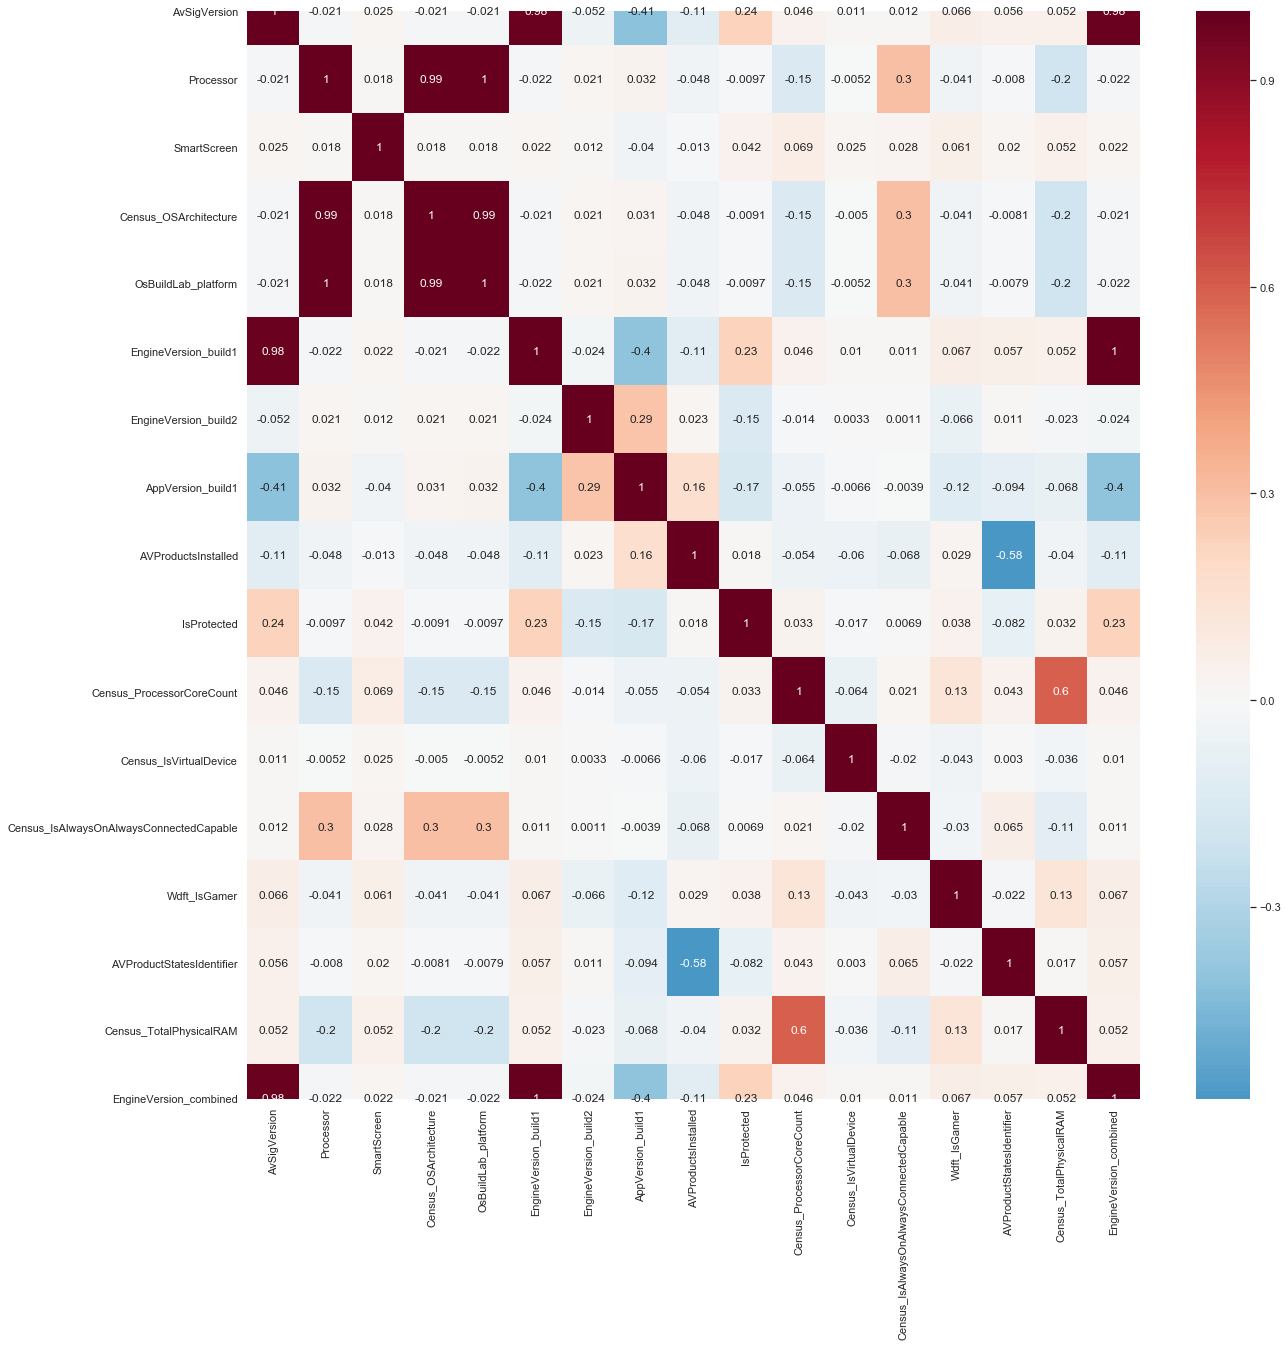

In [20]:
# find columns that correlate with the label

correlated_cols=[]
for col in train_data.columns:
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated numeric variables
        correlated_cols.append(col)
    else:
        star=''
    #print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df_train[correlated_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

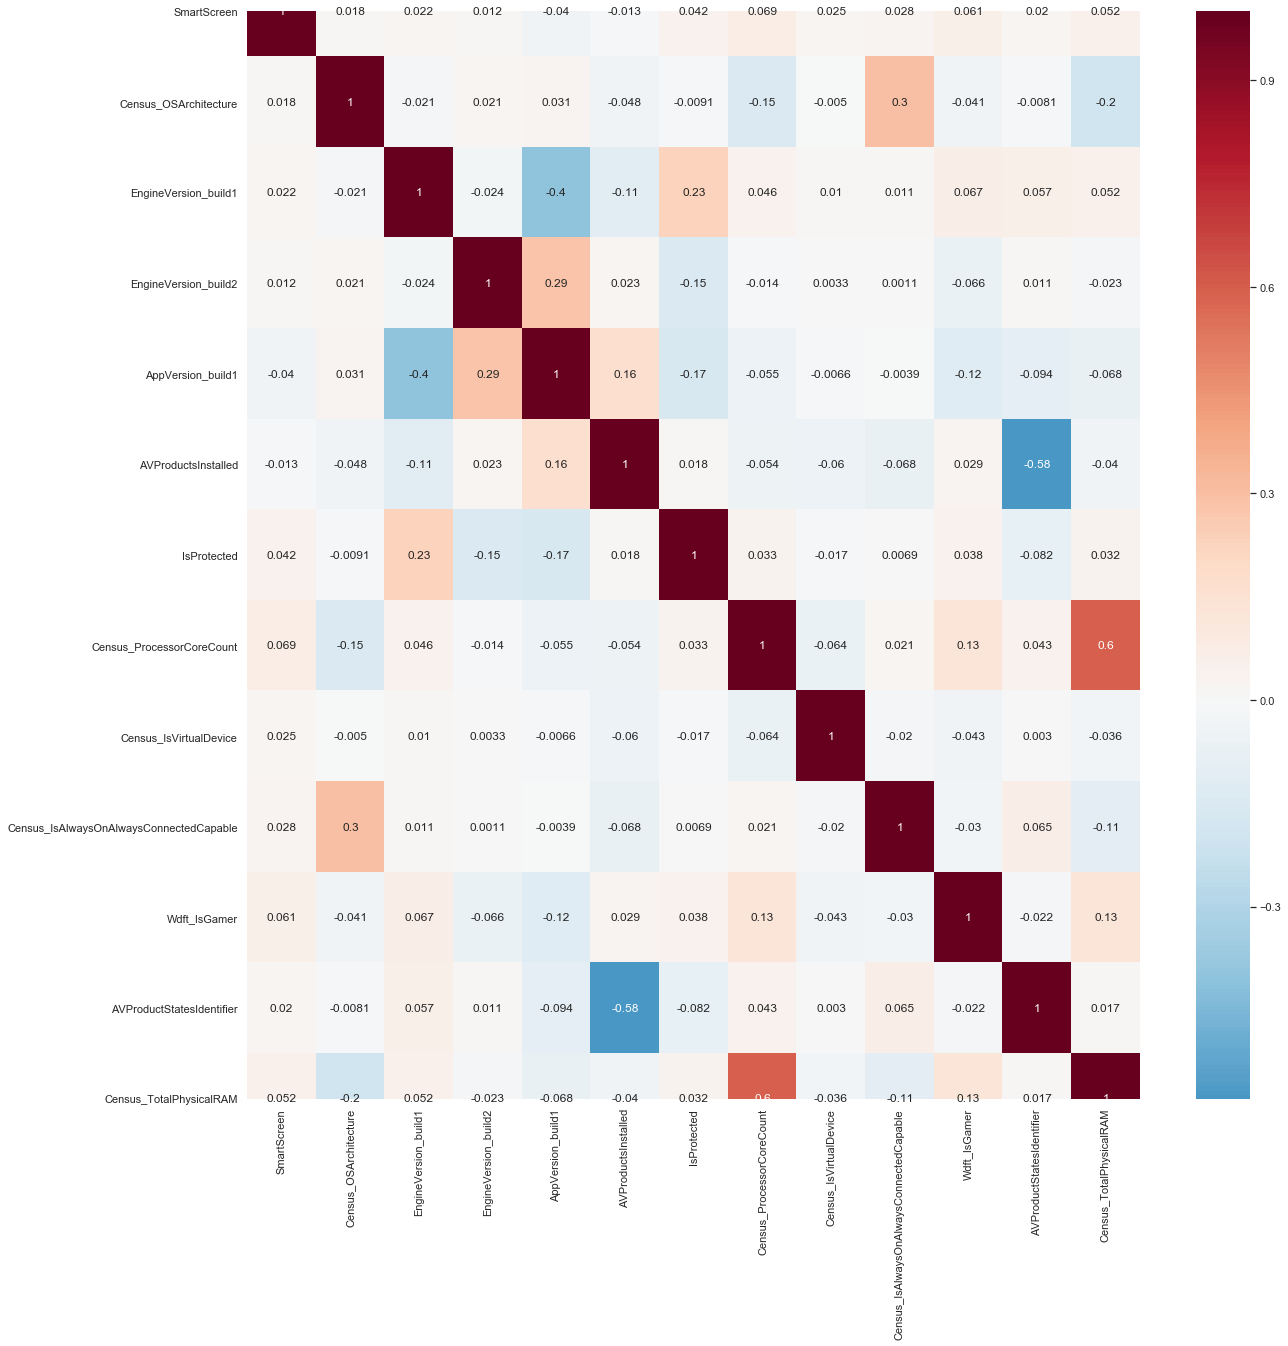

In [21]:
# Remove columns that correlate with one another from the correlation graph

# Keep EngineVersion_build1
correlated_cols.remove('AvSigVersion')
correlated_cols.remove('EngineVersion_combined')

# Keep Census_OSArchitecture
correlated_cols.remove('Processor')
correlated_cols.remove('OsBuildLab_platform')

sns.heatmap(df_train[correlated_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)

In [22]:
# create a train, dev and validate set
X_train_data_corr = train_data[correlated_cols]
X_dev_data_corr = dev_data[correlated_cols]
X_validate_data_corr = validate_data[correlated_cols]

### Selection of Features using SelectFromModel

In [23]:
fsel = ExtraTreesClassifier(n_estimators=100).fit(train_data, train_labels)
model = SelectFromModel(fsel, prefit=True)
X_train_data_sfm = model.transform(train_data)
X_dev_data_sfm = model.transform(dev_data)
X_validate_data_sfm = model.transform(validate_data)
print('selected {:} out of {:} features'.format(
    X_train_data_sfm.shape[1], train_data.shape[1]))


selected 50 out of 148 features


## Models

<a href='#Contents'>[Back to top]</a>

In [24]:
def score_model(model, train_data, train_labels, score_data, score_labels):
    model.fit(X=train_data, y=train_labels)

    # predict and score on the scoring set
    pred = model.predict(score_data)
    
    cm = confusion_matrix(score_labels, pred)
    accuracy = metrics.accuracy_score(y_true=score_labels, y_pred=pred)
    
    return accuracy, cm

### Logistic Regression

One of our async lecturers said that his place of work usually ends up with logistic regression, because with a lot of data, it does almost as well as anything else. We certainly have a lot of data. This was the first model that we decided to employ.

In [25]:
# Model
model_name = "Logistic Regression"
model = LogisticRegression(solver='lbfgs', max_iter=150)

Using Feature Selection through SelectFromModel

In [26]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Logistic Regression using SelectFromModel Feature Selection:

52.9% accuracy

confusion matrix
[[10103 23366]
 [ 8117 25325]]


Using Feature Selection through Correlation Analysis:

In [27]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Logistic Regression using Correlated Feature Selection:

56.7% accuracy

confusion matrix
[[21406 12063]
 [16886 16556]]


### Simple decision tree
With correct feature seletion (i.e. avoiding complete overfitting), this tree did a little better than the other classifiers in Gunnar's initial exploration. 

In [28]:
# Model
model_name = "Decision Tree Classifier"
model = DecisionTreeClassifier()

Using Feature Selection through SelectFromModel:

In [29]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Decision Tree Classifier using SelectFromModel Feature Selection:

56.9% accuracy

confusion matrix
[[19060 14409]
 [14423 19019]]


Using Feature Selection through Correlation Analysis:

In [30]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Decision Tree Classifier using Correlated Feature Selection:

60.8% accuracy

confusion matrix
[[20158 13311]
 [12909 20533]]


### Random Forest Classifier

In [31]:
# Model
model_name = "Random Forest Classifier"
model = RandomForestClassifier(n_estimators=20)

Using Feature Selection through SelectFromModel:

In [32]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Random Forest Classifier using SelectFromModel Feature Selection:

62.2% accuracy

confusion matrix
[[22948 10521]
 [14800 18642]]


Using Feature Selection through Correlation Analysis

In [33]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Random Forest Classifier using Correlated Feature Selection:

61.3% accuracy

confusion matrix
[[20060 13409]
 [12490 20952]]


### Extra Trees Classifier

In [34]:
# Model
model_name = "Extra Trees Classifier"
model = ExtraTreesClassifier(n_estimators=20, min_samples_split=2, random_state=0)

Using Feature Selection through SelectFromModel

In [35]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Extra Trees Classifier using SelectFromModel Feature Selection:

61.7% accuracy

confusion matrix
[[22631 10838]
 [14802 18640]]


Using Feature Selection through Correlation Analysis

In [36]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Extra Trees Classifier using Correlated Feature Selection:

61.1% accuracy

confusion matrix
[[20407 13062]
 [12995 20447]]


### KNN

In [37]:
# Model
model_name = "K-Nearest Neighbor Classifier"
model = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)

Using Feature Selection through SelectFromModel

In [38]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with K-Nearest Neighbor Classifier using SelectFromModel Feature Selection:

51.2% accuracy

confusion matrix
[[16817 16652]
 [15969 17473]]


Using Feature Selection through Correlation Analysis

In [39]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with K-Nearest Neighbor Classifier using Correlated Feature Selection:

60.1% accuracy

confusion matrix
[[20027 13442]
 [13228 20214]]


### Linear SVC

In [40]:
# Model
model_name = "Linear SVC"
model = LinearSVC()

Using Feature Selection through SelectFromModel

In [41]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Linear SVC using SelectFromModel Feature Selection:

49.7% accuracy

confusion matrix
[[15946 17523]
 [16130 17312]]


Using Feature Selection through Correlation Analysis

In [42]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Linear SVC using Correlated Feature Selection:

50.0% accuracy

confusion matrix
[[33461     8]
 [33435     7]]


### Gradient Boosting

In [43]:
# Model
model_name = "Gradient Boosting Classifier"
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.6, max_depth=3, random_state=0)

Using Feature Selection through SelectFromModel

In [44]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Gradient Boosting Classifier using SelectFromModel Feature Selection:

65.2% accuracy

confusion matrix
[[21961 11508]
 [11801 21641]]


Using Feature Selection through Correlation Analysis

In [45]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Gradient Boosting Classifier using Correlated Feature Selection:

63.1% accuracy

confusion matrix
[[20834 12635]
 [12036 21406]]


### Ada Boost

In [46]:
# Model
model_name = "Ada Boosting Classifier"
model = AdaBoostClassifier(n_estimators=100)

Using Feature Selection through SelectFromModel

In [47]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Ada Boosting Classifier using SelectFromModel Feature Selection:

63.6% accuracy

confusion matrix
[[21037 12432]
 [11926 21516]]


Using Feature Selection through Correlation Analysis

In [48]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

score, cm = score_model(model, X_train, y_train, X_score, y_score)

print(f"Predicting with " + model_name + " using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")
print("confusion matrix")
print(cm)

Predicting with Ada Boosting Classifier using Correlated Feature Selection:

62.6% accuracy

confusion matrix
[[19739 13730]
 [11301 22141]]


### PCA

This is using PCA and then GMM clustering. We experimentally determined (in another notebook) that our most promising parameters are:<br>
PCA components = 5, GMM components = 1, covariance type = diagonal


In [49]:
def score_pca_gmm_model (x_train, y_train, x_test, y_test):
    pca = PCA(n_components=5)
    projected = pca.fit_transform(x_train)
    projected_test = pca.transform(x_test)

    gm_mod_pos = GaussianMixture(n_components = 1, reg_covar=.0001, covariance_type='diag')
    gm_mod_pos.fit(projected[y_train==1])

    gm_mod_neg = GaussianMixture(n_components = 1, reg_covar=.0001, covariance_type='diag')
    gm_mod_neg.fit(projected[y_train==0])

    prob_pos = gm_mod_pos.score_samples(projected_test)
    prob_neg = gm_mod_neg.score_samples(projected_test)

    predictions = np.where(prob_pos >= prob_neg, 1, 0)
    accuracy = metrics.accuracy_score(y_test, predictions)
    return accuracy

In [50]:
# Feature Specifications

method = "SelectFromModel"

X_train = X_train_data_sfm
y_train = train_labels
X_score = X_validate_data_sfm
y_score = validate_labels

# Generalized code below:

score = score_pca_gmm_model(X_train, y_train, X_score, y_score)

print(f"Predicting with PCA/GMM using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")


Predicting with PCA/GMM using SelectFromModel Feature Selection:

52.5% accuracy



In [51]:
# Feature Specifications

method = "Correlated"

X_train = X_train_data_corr
y_train = train_labels
X_score = X_validate_data_corr
y_score = validate_labels

# Generalized code below:

# Generalized code below:

score = score_pca_gmm_model(X_train, y_train, X_score, y_score)

print(f"Predicting with PCA/GMM using " + method + " Feature Selection:\n")
print(f"{100*score:0.1f}% accuracy\n")


Predicting with PCA/GMM using Correlated Feature Selection:

60.2% accuracy



### LightGBM Gradient Booster

In [52]:
model_name = "Light GBM Boosting Classifier"

est = HistGradientBoostingClassifier(learning_rate=.1,
                max_iter=100,
                max_bins=100,
                max_leaf_nodes=31,
                n_iter_no_change=None,
                random_state=0,
                verbose=0,
                loss='categorical_crossentropy')

model = get_equivalent_estimator(est, lib='lightgbm')

In [53]:
train_data_corr = train_data[correlated_cols]
dev_data_corr = dev_data[correlated_cols]

X_train = train_data_corr
y_train = train_labels
X_test = dev_data_corr
y_test = validate_labels


est = HistGradientBoostingClassifier(learning_rate=.1,
                max_iter=100,
                max_bins=100,
                max_leaf_nodes=31,
                n_iter_no_change=None,
                random_state=0,
                verbose=0)

est.set_params(loss='binary_crossentropy')

lightgbm_est = get_equivalent_estimator(est, lib='lightgbm')
lightgbm_est.fit(X_train, y_train)

# predict and score on the dev set
pred_y = lightgbm_est.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)


[[21077 12392]
 [12111 21331]]
0.36620286649429845
0.6337971335057015


## NeuralNetwork

<a href='#Contents'>[Back to top]</a>

To explore additional methods of predicting whether a machine had malware, we also built a Neural Network using Pytorch.  The original approach was load all the data at once and then let DataLoader to batch them for optimal training.

However, the CPU operations were intensive and the model (with the full dataset) would take several days to run.  As a result, one of our team members volunteered to use a CUDA-capable device at their emplower. It was faster, but had limited video memory (8GB), so we needed to modify our approach to create smaller chunks of data and use loss-averaging.  The code that follows is this final output.

In [ ]:
# Setup hardware and loading parameters.

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_properties(device))
    chunk_size = 1000000 if not debug else 5 # run in meaningful chunks so that GPU doesn't run out of memory
    epochs = 300 # can do this in 90 min
else:
    device = torch.device('cpu')
    print("running on CPU")
    chunk_size = 10000000 # load all the data at once
    if debug == True:
        epochs = 10 # run shorter because it takes a lot longer
    else:
        epochs = 100 # nobody has time for 300 without a GPU

    
class Model(nn.Module):
    '''This is the NN model.  Instantiation builds the hidden networks, sizes
    and dropout parameters based on the arguments provided'''
    def __init__(self, numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(numerical_cols).to(device)
        all_layers = []
        input_size = numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_data):
        x_data = self.batch_norm_num(x_data)
        x = torch.cat([x_data], 1)
        x = self.layers(x)
        return x

# Iterate and convert all data values
# work on the full dataset, let NN decide which columns are important

train_labels_long = train_labels.astype(np.int64)

cols = []
for c in train_data.columns:
    train_data[c] = train_data[c].astype(np.float64) # Convert dtypes to be all identical for pytorch

# This Instantiates the model with 150 inputs, 4 hidden layers and 2 outputs.
model = Model(len(train_data.columns), 2, [180,50,50,20], p=0.4).to(device)

# Using CrossEntropyLoss because we effectively have an unbalanced training set
# In other words, not all inputs are normalized
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Starting NN training")
start = time.time()

for i in range(epochs):
    
    print(f' Epoch: {i+1:3d}:', end=' ')
    
    rows_left = len(train_data)
    current = 0
    chunk_num = math.ceil(rows_left/chunk_size)

    #
    # do every epoch in chunks
    #
    
    model.zero_grad()
    while rows_left > 0:
        rows = (chunk_size if rows_left >= chunk_size else rows_left)
        chunk = train_data[current:current+rows]
        label_chunk = train_labels_long[current:current+rows]
        
        current += rows
        rows_left -= rows
        
        print(".", end="")
        
        # grab columns and labels, push into device (possibly GPU)
        cols = [chunk[col].values for col in chunk.columns]
        data = np.stack(cols, 1)
        data = torch.tensor(data, dtype=torch.float).to(device)
        target = torch.tensor(label_chunk).to(device)
        
        prediction = model(data)
        single_loss = loss_function(prediction, target)
        single_loss /= chunk_num
        single_loss.backward()

    # after done with all chunks, process the step and reset the gradients
    optimizer.step()
    model.zero_grad()
      
    print(f', loss: {single_loss.item()*chunk_num:1.3f},', end=' ')
    print(f'elapsed: {time.time()-start:5.0f} s')

    

In [62]:
#
# Eval phase
#

model.eval() # switch into eval mode
model.cpu() # get model back into CPU space



# Iterate and convert all data values

test=validate_data
test_labels_long = validate_labels.astype(np.int64)

cols = []
for c in test.columns:
    test[c] = test[c].astype(np.float64) # Convert dtypes to be all identical for pytorch

print(f"Test data: {len(test)} rows, {len(test.columns)} columns")

# grab columns and labels
cols = [test[col].values for col in test.columns]
data = np.stack(cols, 1)
data = torch.tensor(data, dtype=torch.float)

# Make prediction on dev data
output = model(data)
predictions = np.argmax(output.cpu().data.numpy(), axis=1)

# Print NN accuracy and some sample predictions
print("accuracy:", metrics.accuracy_score(y_true=validate_labels, y_pred=predictions))

Test data: 66911 rows, 148 columns
accuracy: 0.4997982394524069


## Conclusion

<a href='#Contents'>[Back to top]</a>

## Appendix

### Other methods for feature selection

Selection of Features using correlation, corplot analysis, and Gunnar's incremental trick (->appendix)

Selection of Features using PCA (with GMM) (-> appendix)

Selection of Features using Ridge Regression (not sure if we want to include) (if so ->appendix)

### Large heatmap

In [ ]:
if False:
    sns.set(rc={'figure.figsize':(100,100)})
    # todo: should this be train_data? Do we take the whole thing out?
    sns.heatmap(df_train.corr(), cmap='RdBu_r', annot=True, center=0.0)